<!--<a href=""><img src="earth.png"></a>-->
![Earth](/python-examples/earth.png)
    
# Python Examples

<DIV align="left" style="line-height:1.5em;">
<p>
    
NASA's Global Imagery Browse Services (GIBS) is a web service for accessing Earth observation imagery. GIBS implements Open Geospatial Consortium (OGC) Web Map Service (WMS) and Web Map Tile Service (WMTS) protocol. It provides more than one thousand of the Earth physical parameters daily for over two decades. This Jupyter Notebook shows how to access GIBS WMS data, WMTS data and how to visualize them on map. It covers getting capabilities, maps, tiles, rasters and vectors. It also includes data request API, XML paring and responded image processing. Finally it shows how to use matplotlib and cartopy packages to display images on various map projections. For more detail of GIBS, please refer to GIBS related introduction:
<a href=https://wiki.earthdata.nasa.gov/display/GIBS/GIBS+API+for+Developers>GIBS API for Developer</a>
    
</p>
</DIV>

## Import Python Packages And Modules

<DIV align="left" style="line-height:1.5em;">
<p>
    
Major packages are requests, xml, json, skiimage, matplotlib, cartopy and pillow image.
    
</p>
</DIV>

In [11]:
import os
from io import BytesIO
from skimage import io
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import urllib.request
import mapbox_vector_tile
import xml.etree.ElementTree as xmlet
import lxml.etree as xmltree
from PIL import Image as plimg
import numpy as np
from owslib.wms import WebMapService
from IPython.display import Image
%matplotlib inline

## Basic WMS Connection

First we will connect to the GIBS WMS Service and visualize the MODIS_Terra_CorrectedReflectance_TrueColor layer.

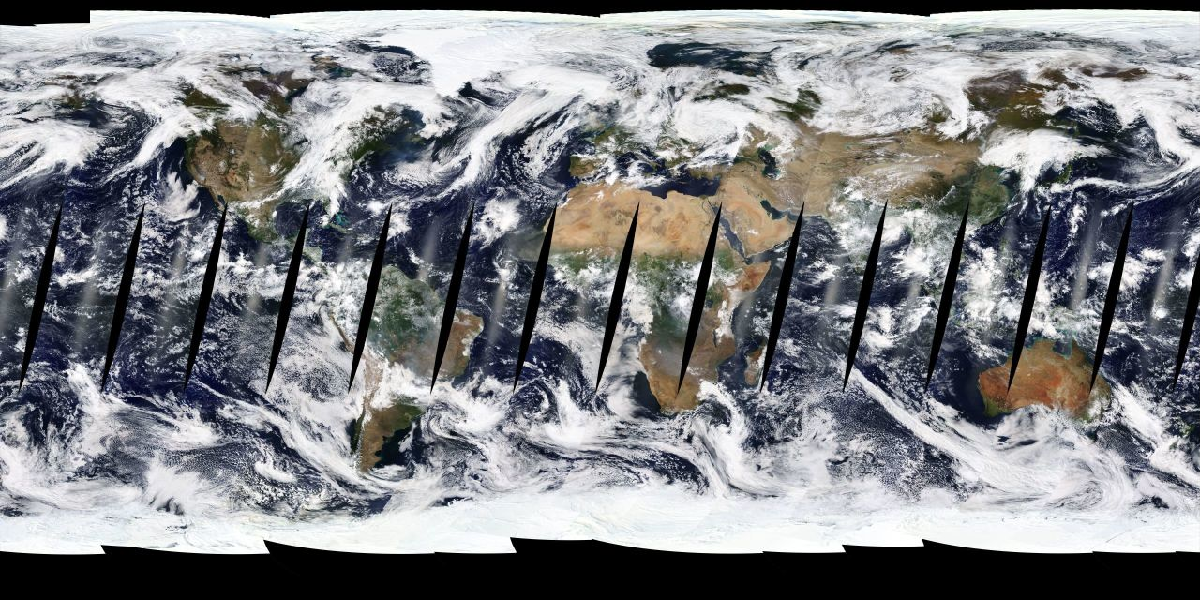

In [12]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.1.1')

# Configure request for MODIS_Terra_CorrectedReflectance_TrueColor
img = wms.getmap(layers=['MODIS_Terra_CorrectedReflectance_TrueColor'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-180,-90,180,90),  # Bounds
                 size=(1200, 600),  # Image size
                 time='2021-09-21',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# Save output PNG to a file
out = open('MODIS_Terra_CorrectedReflectance_TrueColor.png', 'wb')
out.write(img.read())
out.close()

# View image
Image('MODIS_Terra_CorrectedReflectance_TrueColor.png')

## Get WMS Capabilities

<DIV align="left" style="line-height:1.5em;">
<p>
    
For WMS, first is to get capabilities. GIBS provides four map projections, so there are four WMS endpoints to get capabilities:
    
Geographic - EPSG:4326: https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi 
    
Web Mercator - EPSG:3857: https://gibs.earthdata.nasa.gov/wms/epsg3857/best/wms.cgi
    
Arctic polar stereographic - EPSG:3413: https://gibs.earthdata.nasa.gov/wms/epsg3413/best/wms.cgi
    
Antarctic polar stereographic - EPSG:3031: https://gibs.earthdata.nasa.gov/wms/epsg3031/best/wms.cgi
     
The codes below will show how to get capabilities.
</p>
</DIV>

In [13]:
# Construct capability URL.
wmsUrl = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?\
SERVICE=WMS&REQUEST=GetCapabilities'

# Request WMS capabilities.
response = requests.get(wmsUrl)

# Display capabilities XML in original format. Tag and content in one line.
WmsXml = xmltree.fromstring(response.content)
# print(xmltree.tostring(WmsXml, pretty_print = True, encoding = str))

## Display WMS All Layerers

<DIV align="left" style="line-height:1.5em;">
<p>
    
Parse WMS capabilities XML to get total layers and display all layer names.
    
</p>
</DIV>

In [14]:
# Currently total layers are 1081.

# Coverts response to XML tree.
WmsTree = xmlet.fromstring(response.content)

alllayer = []
layerNumber = 0

# Parse XML.
for child in WmsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wms}Capability/{http://www.opengis.net/wms}Layer//*/"): 
         if layer.tag == '{http://www.opengis.net/wms}Layer': 
            f = layer.find("{http://www.opengis.net/wms}Name")
            if f is not None:
                alllayer.append(f.text)
                
                layerNumber += 1

print('There are layers: ' + str(layerNumber))

for one in sorted(alllayer)[:5]:
    print(one)
print('...')
for one in sorted(alllayer)[-5:]:
    print(one)

There are layers: 1152
AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Day
AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Night
AIRS_L2_Cloud_Top_Height_Day
AIRS_L2_Cloud_Top_Height_Night
AIRS_L2_Dust_Score_Day
...
VIIRS_SNPP_L2_Sea_Surface_Temp_Day
VIIRS_SNPP_L2_Sea_Surface_Temp_Night
VIIRS_SNPP_Thermal_Anomalies_375m_All
VIIRS_SNPP_Thermal_Anomalies_375m_Day
VIIRS_SNPP_Thermal_Anomalies_375m_Night


## Search WMS Layer And Its Attributes

<DIV align="left" style="line-height:1.5em;">
<p>
    
Requesting WMS data needs layer name, bounding box, time, projection, data format and so on. Enter a layer
name to search its attributes.
    
</p>
</DIV>

In [15]:
# Define layname to use.
layerName = 'Landsat_WELD_CorrectedReflectance_Bands157_Global_Annual'  

# Get geneal information of WMS.
for child in WmsTree.iter():
    if child.tag == '{http://www.opengis.net/wms}WMS_Capabilities': 
        print('Version: ' +child.get('version'))
    
    if child.tag == '{http://www.opengis.net/wms}Service': 
        print('Service: ' +child.find("{http://www.opengis.net/wms}Name").text)
        
    if child.tag == '{http://www.opengis.net/wms}Request': 
        print('Request: ')
        for e in child:
            print('\t ' + e.tag.partition('}')[2])
                            
        all = child.findall(".//{http://www.opengis.net/wms}Format")
        if all is not None:
            print("Format: ")
            for g in all:
                print("\t " + g.text)     
                
        for e in child.iter():
            if e.tag == "{http://www.opengis.net/wms}OnlineResource":
                print('URL: ' + e.get('{http://www.w3.org/1999/xlink}href'))
                break

# Get layer attributes.
for child in WmsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wms}Capability/{http://www.opengis.net/wms}Layer//*/"): 
         if layer.tag == '{http://www.opengis.net/wms}Layer': 
            f = layer.find("{http://www.opengis.net/wms}Name")
            if f is not None:
                if f.text == layerName:
                    # Layer name.
                    print('Layer: ' + f.text)
                    
                    # All elements and attributes:
                    # CRS
                    e = layer.find("{http://www.opengis.net/wms}CRS")
                    if e is not None:
                        print('\t CRS: ' + e.text)
                    
                    # BoundingBox.
                    e = layer.find("{http://www.opengis.net/wms}EX_GeographicBoundingBox")
                    if e is not None:
                        print('\t LonMin: ' + e.find("{http://www.opengis.net/wms}westBoundLongitude").text)
                        print('\t LonMax: ' + e.find("{http://www.opengis.net/wms}eastBoundLongitude").text)
                        print('\t LatMin: ' + e.find("{http://www.opengis.net/wms}southBoundLatitude").text)
                        print('\t LatMax: ' + e.find("{http://www.opengis.net/wms}northBoundLatitude").text)
                    
                    # Time extent.
                    e = layer.find("{http://www.opengis.net/wms}Dimension")
                    if e is not None:
                        print('\t TimeExtent: ' + e.text)
                        
                    # Style.
                    e = layer.find("{http://www.opengis.net/wms}Style")
                    if e is not None:
                        f = e.find("{http://www.opengis.net/wms}Name")
                        if f is not None:
                            print('\t Style: ' + f.text)

print('')                         

Version: 1.3.0
Service: WMS
Request: 
	 GetCapabilities
	 GetMap
Format: 
	 text/xml
	 image/png
	 application/vnd.google-earth.kml.xml
	 application/vnd.google-earth.kmz
	 image/jpeg
	 image/png; mode=8bit
	 image/vnd.jpeg-png
	 image/vnd.jpeg-png8
	 image/tiff
	 application/json
URL: https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?
Layer: Landsat_WELD_CorrectedReflectance_Bands157_Global_Annual
	 CRS: EPSG:4326
	 LonMin: -180
	 LonMax: 180
	 LatMin: -90
	 LatMax: 90
	 TimeExtent: 1983-12-01/1985-12-01/P1Y,1988-12-01/1990-12-01/P1Y,1998-12-01/2000-12-01/P1Y



## Visualize WMS Raster Data In Geographic Projection

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get Ggeographic projection (EPSG:4326) image. Use a layer name and its attributes to form a URL for requesting WMS image. After a responded image is returned, display it in map by matplotlib and cartopy. 
    
</p>
</DIV>

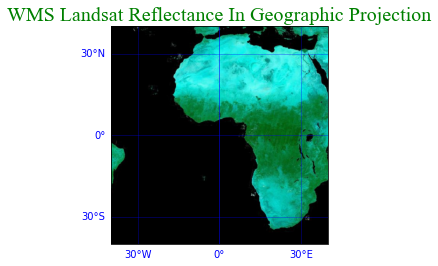

In [16]:
#  Construct Geographic projection URL.
proj4326 = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?\
version=1.3.0&service=WMS&\
request=GetMap&format=image/png&STYLE=default&bbox=-40,-40,40,40&CRS=EPSG:4326&\
HEIGHT=600&WIDTH=600&TIME=2000-12-01&layers=Landsat_WELD_CorrectedReflectance_Bands157_Global_Annual'

# Request image.
img = io.imread(proj4326)

# Display image on map.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
extent = (-40, 40, -40, 40)
plt.imshow(img, transform = ccrs.PlateCarree(), extent = extent, origin = 'upper')

# Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'blue', alpha = 0.3,  draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator([0, 30, -30, 0])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'blue'}
gl.ylabel_style = {'color': 'blue'}

plt.title('WMS Landsat Reflectance In Geographic Projection',\
          fontname = "Times New Roman", fontsize = 20, color = 'green')

plt.show()

print('')

## Visualize WMS Raster Data In Web Mercator Projection

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get image in WMS Web Mercator projection (EPSG:3857) and display it on map.
    
</p>
</DIV>

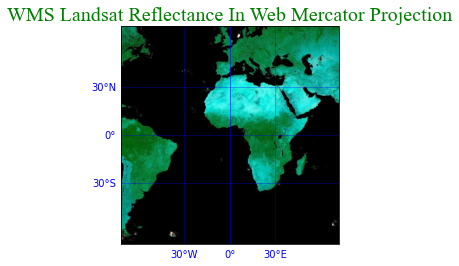

In [17]:
# Construct Web Mercator projection URL.
proj3857 = 'https://gibs.earthdata.nasa.gov/wms/epsg3857/best/wms.cgi?\
version=1.3.0&service=WMS&\
request=GetMap&format=image/png&STYLE=default&bbox=-8000000,-8000000,8000000,8000000&\
CRS=EPSG:3857&HEIGHT=600&WIDTH=600&TIME=2000-12-01&layers=Landsat_WELD_CorrectedReflectance_Bands157_Global_Annual'

# Request image.
img=io.imread(proj3857)

# Display image on map.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mercator.GOOGLE)
extent = (-8000000, 8000000, -8000000, 8000000)
plt.imshow(img, transform = ccrs.Mercator.GOOGLE, extent = extent, origin = 'upper')

# Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'blue', alpha = 0.3,  draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator([0, 30, -30, 0])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'blue'}
gl.ylabel_style = {'color': 'blue'}

plt.title('WMS Landsat Reflectance In Web Mercator Projection',
          fontname = "Times New Roman", fontsize = 20, color = 'green')

plt.show()

print('')

## Visualize WMS Raster Data In Arctic Polar Stereographic Projection

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get WMS Arctic Polar Stereographic projection (EPSG:3413) image and display it on map.
    
</p>
</DIV>

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


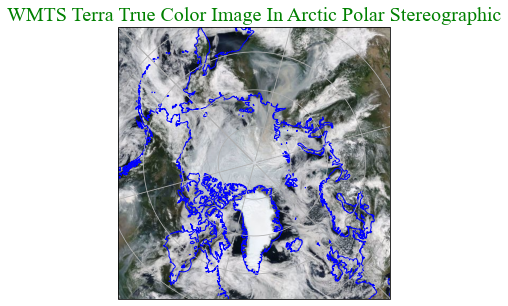

In [18]:
# Construct Arctic Polar Stereographic projection URL.
proj3413 = 'https://gibs.earthdata.nasa.gov/wms/epsg3413/best/wms.cgi?\
version=1.3.0&service=WMS&request=GetMap&\
format=image/png&STYLE=default&bbox=-4194300,-4194300,4194300,4194300&CRS=EPSG:3413&\
HEIGHT=512&WIDTH=512&TIME=2021-08-01&layers=MODIS_Terra_CorrectedReflectance_TrueColor'

# Request image.
img = io.imread(proj3413) 

# Display image on map.
plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))
plt.imshow(img, extent = (-4194300,4194300,-4194300,4194300), origin = 'upper')

# Draw coastline and grid.
ax.coastlines(color='blue', linewidth=1)
ax.gridlines()

plt.title('WMTS Terra True Color Image In Arctic Polar Stereographic',\
          fontname = "Times New Roman", fontsize = 20, color = 'green')

plt.show()
 
print('')

## Visualize WMS Raster Data In Antarctic Polar Stereographic Projection

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get WMS Antarctic Polar Stereographic projection (EPSG:3031) image and display it on map.
    
</p>
</DIV>

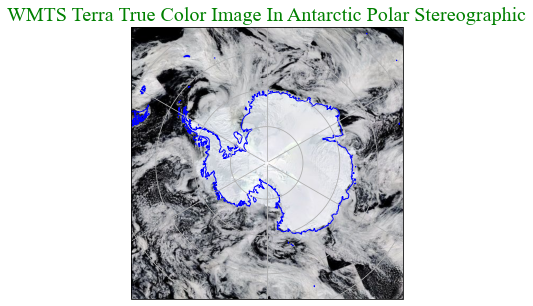

In [19]:
# Construct Antarctic Polar Stereographic project 
proj3031 = 'https://gibs.earthdata.nasa.gov/wms/epsg3031/best/wms.cgi?\
version=1.3.0&service=WMS&request=GetMap&\
format=image/png&STYLE=default&bbox=-4194300,-4194300,4194300,4194300&CRS=EPSG:3031&\
HEIGHT=512&WIDTH=512&TIME=2021-03-01&layers=MODIS_Terra_CorrectedReflectance_TrueColor'

# Request image.
img = io.imread(proj3031) 

# Display image on map.
plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.imshow(img, extent = (-4194300,4194300,-4194300,4194300), origin = 'upper')

# Draw coastline and grid.
ax.coastlines(color='blue', linewidth=1)
ax.gridlines()

plt.title('WMTS Terra True Color Image In Antarctic Polar Stereographic',\
          fontname = "Times New Roman", fontsize = 20, color = 'green')

plt.show()
 
print('')

## Visualize WMS Global Raster Data

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get WMS global image and to display it on map.
    
</p>
</DIV>

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


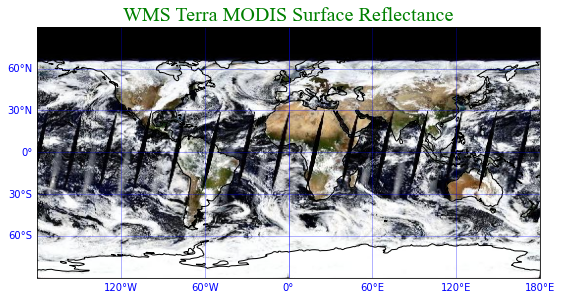

In [20]:
# Construct global image URL.
proj4326 = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?\
version=1.3.0&service=WMS&request=GetMap&\
format=image/jpeg&STYLE=default&bbox=-90,-180,90,180&CRS=EPSG:4326&\
HEIGHT=512&WIDTH=512&TIME=2021-11-25&layers=MODIS_Terra_SurfaceReflectance_Bands143'

# Request image.
img = io.imread(proj4326) 

# Display image on map.
plt.figure(figsize = (9, 6))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 0))
cmp = plt.imshow(img, transform = ccrs.PlateCarree(), extent = (-180,180,-90,90), origin = 'upper')

# Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'blue', alpha = 0.3,  draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator([0, 60, 120, 180, -120, -60, 0])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'blue'}
gl.ylabel_style = {'color': 'blue'}

# Draw coastline.
ax.coastlines()

plt.title('WMS Terra MODIS Surface Reflectance',fontname="Times New Roman", fontsize = 20, color = 'green')

plt.show()
 
print('')

## Visualize WMS Global Vector Data

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get WMS global vector data and to display it on map.
    
</p>
</DIV>

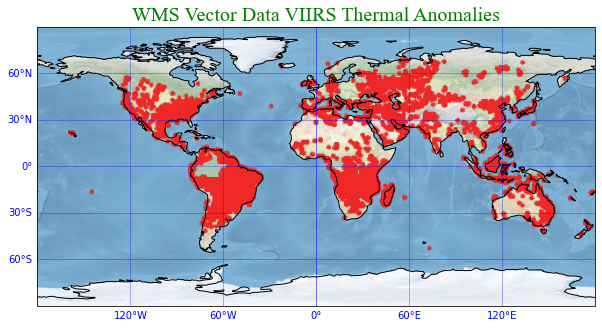

In [21]:
# Construct WMS global vector URL.
wmsVector = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?\
TIME=2020-10-01T00:00:00Z&\
LAYERS=VIIRS_NOAA20_Thermal_Anomalies_375m_All&REQUEST=GetMap&SERVICE=WMS&\
FORMAT=image/png&WIDTH=480&HEIGHT=240&VERSION=1.1.1&SRS=epsg:4326&BBOX=-180,-90,180,90&TRANSPARENT=TRUE'

# Request image.
img = io.imread(wmsVector)

# Setup map size, projection and background.
fig = plt.figure(figsize = (10, 6))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 0))
ax.set_facecolor("white")
ax.stock_img()
ax.coastlines()

# Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'blue', alpha = 0.3,  draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator([0, 60, 120, -120, -60, 0])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'blue'}
gl.ylabel_style = {'color': 'blue'}

# Display image on map.
extent = (-180, 180, -90, 90)
plt.imshow(img, extent = extent)

plt.title('WMS Vector Data VIIRS Thermal Anomalies',\
          fontname = "Times New Roman", fontsize = 20, color = 'green')

print('')

## Interactive Web Map with WMS

The next example shows how to display VIIRS_NOAA20_Thermal_Anomalies_375m_All layer in an interactive web map (may require additional Python libraries).

In [23]:
from ipyleaflet import Map, WMSLayer, basemaps

# Make a WMS connection to a map layer
wms_layer = WMSLayer(url='https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?',
                     layers='VIIRS_NOAA20_Thermal_Anomalies_375m_All',
                     format='image/png',
                     transparent=True)

# Define map properties and add the WMS layer from above on top of basemap
m = Map(basemap=basemaps.NASAGIBS.BlueMarble, center=(0, -0), zoom=3)
m.add_layer(wms_layer)

# Display interactive web map
m

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

## Get WMTS Capabilities

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get WMTS capabilities and display capability XML content.
    
</p>
</DIV>

In [ ]:
# Construct WMTS capability URL.
wmtsUrl = 'http://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi?SERVICE=WMTS&REQUEST=GetCapabilities'

# Request capabilities.
response = requests.get(wmtsUrl)

# Display capability XML.
WmtsXml = xmltree.fromstring(response.content)
# print(xmltree.tostring(WmtsXml, pretty_print = True, encoding = str))

## Display WMTS All Layers of capabilities.

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to parse WMTS capabilities and to display all layers of capabilities.
    
</p>
</DIV>

In [ ]:
# Currently total layers are 1026.  

# Convert capability response to XML tree.
WmtsTree = xmlet.fromstring(response.content)

alllayer = []
layerNumber = 0

# Parse capability XML tree.
for child in WmtsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wmts/1.0}Layer"): 
         if '{http://www.opengis.net/wmts/1.0}Layer' == layer.tag: 
            f=layer.find("{http://www.opengis.net/ows/1.1}Identifier")
            if f is not None:
                alllayer.append(f.text)
                layerNumber += 1

print('There are layers: ' + str(layerNumber))
for one in sorted(alllayer)[:5]:
    print(one)
print('...')
for one in sorted(alllayer)[-5:]:
    print(one)       

There are layers: 1041
AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Day
AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Night
AIRS_L2_Cloud_Top_Height_Day
AIRS_L2_Cloud_Top_Height_Night
AIRS_L2_Dust_Score_Day
...
VIIRS_SNPP_L2_Sea_Surface_Temp_Day
VIIRS_SNPP_L2_Sea_Surface_Temp_Night
VIIRS_SNPP_Thermal_Anomalies_375m_All
VIIRS_SNPP_Thermal_Anomalies_375m_Day
VIIRS_SNPP_Thermal_Anomalies_375m_Night


## Search WMTS Vector Layer, Attributes And Vector Information

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to search a WMTS layer and to parse its attributes and vector information.
    
</p>
</DIV>

In [ ]:
# Get general information of WMTS from XML tree.
for child in WmtsTree.iter():
    if child.tag == '{http://www.opengis.net/wmts/1.0}Capabilities': 
        print('Version: ' + child.get('version'))
    
    if child.tag == '{http://www.opengis.net/ows/1.1}ServiceType': 
        print('Service: ' + child.text)
        
    if child.tag == '{http://www.opengis.net/ows/1.1}OperationsMetadata': 
        print('Request: ')
        for e in child:
            print('\t ' + e.get('name'))

# Parse layer attributes and vector information.
for child in WmtsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wmts/1.0}Layer"): 
         if '{http://www.opengis.net/wmts/1.0}Layer' == layer.tag: 
            f = layer.find("{http://www.opengis.net/ows/1.1}Identifier")
            if f is not None:
                if f.text == 'MODIS_Aqua_Thermal_Anomalies_All':
                    # Layer name.
                    print('Layer: ' + f.text)
                    
                    # All elements and attributes:
                    
                    # BoundingBox.
                    e = layer.find("{http://www.opengis.net/ows/1.1}WGS84BoundingBox")
                    if e is not None:
                        print("\t crs: " + e.get('crs'))
                        print("\t UpperCorner: " + e.find("{http://www.opengis.net/ows/1.1}UpperCorner").text)
                        print("\t LowerCorner: " + e.find("{http://www.opengis.net/ows/1.1}LowerCorner").text)
                    
                    # TileMatrixSet.
                    e = layer.find("{http://www.opengis.net/wmts/1.0}TileMatrixSetLink")
                    if e is not None:
                        print("\t TileMatrixSet: " + e.find("{http://www.opengis.net/wmts/1.0}TileMatrixSet").text)
                        
                    # Time extent.
                    e = layer.find("{http://www.opengis.net/wmts/1.0}Dimension")
                    if e is not None:
                        all = e.findall("{http://www.opengis.net/wmts/1.0}Value")
                        if all is not None:
                            print("\t TimeExtent: ")
                            for g in all:
                                print("\t\t " + g.text)
                        
                    # Foramt.
                    e = layer.find("{http://www.opengis.net/wmts/1.0}Format")
                    if e is not None:
                        print("\t Format: " + e.text)
                    
                    # Style.
                    e = layer.find("{http://www.opengis.net/wmts/1.0}Style")
                    if e is not None:
                        g=e.find("{http://www.opengis.net/ows/1.1}Identifier")
                        if g is not None:
                            print("\t Style: " + g.text)
                       
                    # Template.
                    e = layer.find("{http://www.opengis.net/wmts/1.0}ResourceURL")
                    if e is not None:
                        print("\t Template: " + e.get('template'))
                        
                    # Vector metadata.                    
                    for e in layer.findall("{http://www.opengis.net/ows/1.1}Metadata"):
                        if "vector-metadata" in e.get("{http://www.w3.org/1999/xlink}href"):
                            vectorMetadata=e.get("{http://www.w3.org/1999/xlink}href")
                            print('\t Vector metadata: ' + vectorMetadata)
                                  
                            response = urllib.request.urlopen(vectorMetadata)

                            # Load to json.
                            data = json.loads(response.read())

                            #Parse json.
                            for p in data['mvt_properties']:
                                keys = list(p.keys())
                                if 'Identifier' in keys:
                                    print('\t\t Identifier: ' + p['Identifier'])
                                if 'Title' in keys:
                                    print('\t\t Title: ' + p['Title'])
                                if 'Description' in keys:
                                    print('\t\t Description: ' + p['Description'])
                                if 'Units' in keys:
                                    print('\t\t Units: ' + p['Units'])
                                if 'DataType' in keys:
                                    print('\t\t DataType: ' + p['DataType'])
                                if 'ValueRanges' in keys:
                                    print('\t\t ValueRanges: ' + str(p['ValueRanges']))
                                if 'ValueMap' in keys:
                                    print('\t\t ValueMap: ' + str(p['ValueMap']))   
                                if 'Function' in keys:
                                    print('\t\t Function: ' + p['Function'])
                                if 'IsOptional' in keys:
                                    print('\t\t IsOptional: ' + str(p['IsOptional']))
                                if 'IsLabel' in keys:
                                    print('\t\t IsLabel: ' + str(p['IsLabel']))
                                
                                print('\n')
                            
                            # There two vector metadata. Only need one, so break.
                            break      
                    
print('')

Version: 1.0.0
Service: OGC WMTS
Request: 
	 GetCapabilities
	 GetTile
Layer: MODIS_Aqua_Thermal_Anomalies_All
	 crs: urn:ogc:def:crs:OGC:2:84
	 UpperCorner: 180 90
	 LowerCorner: -180 -90
	 TileMatrixSet: 1km
	 TimeExtent: 
		 2002-07-04/2002-07-29/P1D
		 2002-08-08/2002-09-12/P1D
		 2002-09-14/2020-08-16/P1D
		 2020-09-02/2021-12-31/P1D
	 Format: application/vnd.mapbox-vector-tile
	 Style: default
	 Template: https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/MODIS_Aqua_Thermal_Anomalies_All/default/{Time}/{TileMatrixSet}/{TileMatrix}/{TileRow}/{TileCol}.mvt
	 Vector metadata: https://gibs.earthdata.nasa.gov/vector-metadata/v1.0/FIRMS_MODIS_Thermal_Anomalies.json
		 Identifier: LATITUDE
		 Title: Latitude
		 Description: Latitude in Decimal Degrees
		 Units: °
		 DataType: float
		 Function: Describe
		 IsOptional: False
		 IsLabel: False


		 Identifier: LONGITUDE
		 Title: Longitude
		 Description: Longitude in Decimal Degrees
		 Units: °
		 DataType: float
		 Function: Describe
		

## Read WMTS Vector Data

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get one of WMTS vector data (MVT) from previous vector information. Also shows to parse vector data values.
    
</p>
</DIV>

In [ ]:
# Vector data format.
'''
{
   'MODIS_Aqua_Thermal_Anomalies_All':
   {
    'extent': 4096,
    'version': 1, 
    'features': 
    [
        {'geometry': 
            {'type': 'Point', 
             'coordinates': [4028, 3959]}, 
             'properties': {'LATITUDE': 35.397, 
                            'LONGITUDE': -90.3, 
                            'BRIGHTNESS': 307.3, 
                            'SCAN': 3.2, 
                            'TRACK': 1.7, 
                            'ACQ_DATE': '2020-10-01', 
                            'ACQ_TIME': '18:30', 
                            'SATELLITE': 'A', 
                            'CONFIDENCE': 48, 
                            'VERSION': '6.0NRT', 
                            'BRIGHT_T31': 296.0, 
                            'FRP': 21.4, 
                            'DAYNIGHT': 'D', 
                            'UID': 13159}, 
                            'id': 0,
                            'type': 1
                           }
            }
        }
        ,,,
    ]
}
'''

# Below both kvp and restful methods work. 
'''
kvp = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi?\
TIME=2020-10-01T00:00:00Z&FORMAT=application/vnd.mapbox-vector-tile&\
layer=MODIS_Aqua_Thermal_Anomalies_All&tilematrixset=1km&\
Service=WMTS&Request=GetTile&Version=1.0.0&TileMatrix=4&TileCol=3&TileRow=3'
response = requests.get(kvp)
'''

restful = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/MODIS_Aqua_Thermal_Anomalies_All\
/default/2020-10-01T00:00:00Z/1km/4/3/4.mvt'

# Request data.
response = requests.get(restful)

# Parse vector values.
data = response.content
dataDictionary = mapbox_vector_tile.decode(data)
for key in dataDictionary.keys():
    parameterDictionary = dataDictionary[key]
    features = parameterDictionary['features']
    # Print vector data format.
    #print(features)

    lat = []
    lon = []
    brightness = []
    for f in features:
        p = f['properties']
        lat.append(p['LATITUDE'])
        lon.append(p['LONGITUDE'])
        brightness.append(p['BRIGHTNESS'])
        
print('lat number: ' + str(len(lat)))
print(str(lat))
print('lon number: ' + str(len(lon)))
print(str(lon))
print('brightness number: ' + str(len(brightness)))
print('brightness min: ' + str(min(brightness)))
print('brightness min: ' + str(max(brightness)))
print(str(brightness))

print('')

lat number: 81
[35.397, 35.403, 35.405, 35.446, 35.45, 35.454, 35.467, 35.47, 35.484, 36.053, 33.225, 33.449, 33.45, 33.451, 33.451, 33.625, 33.627, 33.755, 33.756, 33.77, 33.8, 33.803, 33.853, 33.853, 33.855, 33.867, 34.076, 34.346, 34.356, 34.457, 31.032, 31.034, 31.046, 31.048, 31.365, 31.608, 31.89, 31.892, 31.899, 18.316, 19.026, 19.091, 19.094, 19.232, 19.592, 19.594, 19.639, 19.653, 19.8, 19.808, 19.961, 20.518, 20.601, 20.611, 20.723, 20.725, 21.151, 21.726, 21.728, 21.911, 22.04, 22.917, 23.775, 25.189, 25.191, 25.228, 25.723, 25.843, 27.436, 27.447, 28.799, 28.801, 28.914, 29.095, 29.096, 29.527, 29.529, 29.529, 29.531, 29.561, 29.805]
lon number: 81
[-90.3, -90.272, -90.266, -90.676, -90.67, -90.641, -92.205, -92.215, -92.209, -89.904, -91.815, -94.62, -94.167, -94.593, -94.589, -93.99, -93.982, -94.507, -94.516, -94.509, -93.806, -93.798, -94.621, -94.626, -94.594, -94.627, -96.957, -91.197, -91.157, -91.021, -95.208, -95.182, -95.209, -95.183, -98.348, -95.122, -90.842, -9

## Display WMTS Vector Data

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to overlay WMTS vector data values from last cell on map with legend.
    
</p>
</DIV>

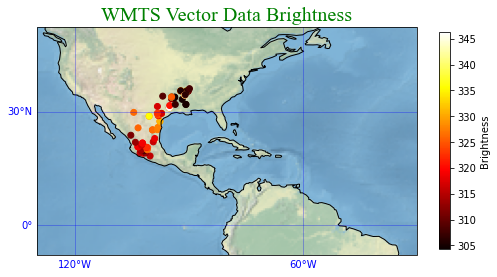

In [ ]:
# Setup map size and projection.
fig = plt.figure(figsize = (8, 5))

ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 0))

# x min, x max, y min, y max.
extent = (-130,-30,-5,40)
ax.set_extent(extent)

# Plot lat, lon and brightness.
cmp = ax.scatter(lon, lat, c = brightness, cmap = 'hot')

# Plot legend.
cb = plt.colorbar(cmp, orientation='vertical',
                  fraction = 0.1, pad = 0.05, shrink = 0.8, label = 'Brightness'
                  ).outline.set_visible(True)

# Draw background.
ax.stock_img()
ax.coastlines()

# Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth=1, color = 'blue', alpha = 0.3,  draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator([0, 60, 120, -120, -60, 0])
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'blue'}
gl.ylabel_style = {'color': 'blue'}

plt.title('WMTS Vector Data Brightness',\
          fontname = "Times New Roman", fontsize = 20, color = 'green')

plt.show()

print('')

## Visualize WMTS Raster Data By GDAL

<DIV align="left" style="line-height:1.5em;">
<p>
    
This example shows how to get WMTS raster data by GDAL and to display it in map.

The Geospatial Data Abstraction Library (GDAL) has minidrivers to access WMS. please refer to the minidrivers
for detail: <a href=https://gdal.org/drivers/raster/wms.html>GDAL minidrivers</a>
 
First make XML file like in next cell and save it as globe.xml file.
Then at command line, run:
gdal_translate -of JPEG -outsize 1200 600 -projwin -180 90 180 -90 globe.xml globe.jpg
    
</p>
</DIV>

In [ ]:
# Make GDAL input XML file like globe.xml below.
xml = xmltree.parse("globe.xml")
pretty = xmltree.tostring(xml, encoding="unicode", pretty_print=True)
print(pretty)

<GDAL_WMS>
    <Service name="TMS">
        <ServerUrl>https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/MODIS_Terra_CorrectedReflectance_TrueColor/default/2021-11-25/250m/${z}/${y}/${x}.jpg</ServerUrl>
    </Service>
    <Transparent>TRUE</Transparent>
    <DataWindow>
        <UpperLeftX>-180.0</UpperLeftX>
        <UpperLeftY>90</UpperLeftY>
        <LowerRightX>396.0</LowerRightX>
        <LowerRightY>-198</LowerRightY>
        <TileLevel>8</TileLevel>
        <TileCountX>2</TileCountX>
        <TileCountY>1</TileCountY>
        <YOrigin>top</YOrigin>
    </DataWindow>
    <BlockSizeX>512</BlockSizeX>
    <BlockSizeY>512</BlockSizeY>
    <Projection>EPSG:4326</Projection>
    <BandsCount>3</BandsCount>
</GDAL_WMS>



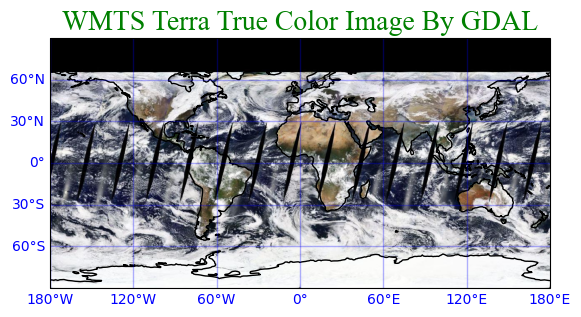

In [ ]:
# Run GDAL command.
cmd  = 'gdal_translate -of JPEG -outsize 1200 600 -projwin -180 90 180 -90 globe.xml globe.jpg'
os.system(cmd)

# Output image is globe.jpg.
img = plimg.open('globe.jpg')

# Setup map size and projection.
fig = plt.figure(figsize = (5, 10), dpi = 100)
ax = plt.axes([1, 1, 1, 1], projection = ccrs.PlateCarree(central_longitude = 0))
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])

# Display image on map.
imgExtent = (-180,180,-90,90)
cmp = plt.imshow(img, extent = imgExtent)

# Draw coastline.
ax.coastlines()

# Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'blue', alpha = 0.3,  draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
#gl.xlocator = mticker.FixedLocator([0, 60, 120, -120, -60])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'blue'}
gl.ylabel_style = {'color': 'blue'}

plt.title('WMTS Terra True Color Image By GDAL',\
          fontname = "Times New Roman", fontsize = 20, color = 'green')

plt.show()

print('')